In [1]:
"""
Train convex LassoNet models on a synthetic classification dataset using conve|x optimization.
"""

import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from convex_nn.private.utils.data import gen_classification_data


from convex_nn.models import ConvexGatedReLU, ConvexReLU
from convex_nn.solvers import RFISTA, AL
from convex_nn.regularizers import NeuronGL1
from convex_nn.metrics import Metrics
from convex_nn.activations import sample_gate_vectors
from convex_nn.optimize import optimize_model, optimize

In [3]:
# Generate realizable synthetic classification problem (ie. Figure 1)
n_train = 1000
n_test = 1000
d = 50
hidden_units = 100
kappa = 10  # condition number

(X_train, y_train), (X_test, y_test) = gen_classification_data(123, n_train, n_test, d, hidden_units, kappa)

In [4]:
lam = 0.001
max_neurons = 500

In [26]:
model, metrics = optimize("gated_relu", 
                          max_neurons, 
                          lam, 
                          X_train, 
                          y_train, 
                          X_test, 
                          y_test, 
                          verbose=True, 
                          backend="torch", 
                          device="cuda")

AssertionError: 

In [20]:
# Instantiate convex model and other options.
G = sample_gate_vectors(np.random.default_rng(123), d, max_neurons)
model = ConvexGatedReLU(G)
solver = RFISTA(model, tol=1e-10)
regularizer = NeuronGL1(lam)
metrics = Metrics(metric_freq=25, model_loss=True, train_accuracy=True, train_mse=True, test_mse=True, test_accuracy=True, neuron_sparsity=True)

In [21]:
grelu_model, grelu_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer,
    verbose=True,
)

INFO:convex_nn:Pre-Optimization Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.08310095965862274, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set nc_squared_error: 0.5, Test Set nc_accuracy: 0.0, Test Set squared_error: 0.5, group_sparsity: 1.0, 


fista:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.5, Train Set grad_norm: 0.08310095965862274, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set nc_squared_error: 0.5, Test Set nc_accuracy: 0.0, Test Set squared_error: 0.5, group_sparsity: 1.0, 
Train Set objective: 0.11960908699035645, Train Set grad_norm: 7.062554232106777e-06, Train Set base_objective: 0.11960908699035645, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.030168588638305665, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11168362426757812, group_sparsity: 0.006, 
Train Set objective: 0.1157255973815918, Train Set grad_norm: 2.0013769699289696e-06, Train Set base_objective: 0.1157255973815918, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029887596130371095, Test Set nc_accuracy: 0.941, Test Set squared_error: 0.10983995819091796, group_sparsity: 0.276, 
Train Set objective: 0.11423622512817383, Train Set grad_norm: 8.817787602311e-07, Train Set base_objective: 0.11423622512817383, Train Set accuracy: 1.0, 

Train Set objective: 0.11362676620483399, Train Set grad_norm: 1.260352378018581e-10, Train Set base_objective: 0.11362676620483399, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029317834854125976, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420061492919922, group_sparsity: 0.718, 
Train Set objective: 0.11362675857543945, Train Set grad_norm: 1.2707711272152977e-10, Train Set base_objective: 0.11362675857543945, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029317981719970704, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420069885253906, group_sparsity: 0.718, 
Train Set objective: 0.11362675476074219, Train Set grad_norm: 1.2903057788893335e-10, Train Set base_objective: 0.11362675476074219, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029318267822265626, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420089721679688, group_sparsity: 0.718, 
Train Set objective: 0.11362676239013672, Train Set grad_norm: 1.2913201064002067e-

Train Set objective: 0.11362675666809081, Train Set grad_norm: 1.3846618296398105e-10, Train Set base_objective: 0.11362675666809081, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029318363189697265, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420079040527344, group_sparsity: 0.718, 
Train Set objective: 0.11362676620483399, Train Set grad_norm: 1.3871723214542442e-10, Train Set base_objective: 0.11362676620483399, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029318340301513673, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420077514648437, group_sparsity: 0.718, 
Train Set objective: 0.11362675857543945, Train Set grad_norm: 1.3900991469029123e-10, Train Set base_objective: 0.11362675857543945, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931833267211914, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420076751708984, group_sparsity: 0.718, 
Train Set objective: 0.11362676239013672, Train Set grad_norm: 1.394517001873652e-1

Train Set objective: 0.11362676620483397, Train Set grad_norm: 1.614069572442034e-10, Train Set base_objective: 0.11362676620483397, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931917953491211, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420121765136719, group_sparsity: 0.718, 
Train Set objective: 0.11362676239013672, Train Set grad_norm: 1.619424178089801e-10, Train Set base_objective: 0.11362676239013672, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931920623779297, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420123291015626, group_sparsity: 0.718, 
Train Set objective: 0.11362676620483399, Train Set grad_norm: 1.6214411757697889e-10, Train Set base_objective: 0.11362676620483399, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931916618347168, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420120239257812, group_sparsity: 0.718, 
Train Set objective: 0.11362676239013672, Train Set grad_norm: 1.6303321193067433e-10, 

Train Set objective: 0.11362676239013672, Train Set grad_norm: 1.8250399802521855e-10, Train Set base_objective: 0.11362676239013672, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029318946838378906, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420097351074218, group_sparsity: 0.716, 
Train Set objective: 0.11362675857543945, Train Set grad_norm: 1.842121594153312e-10, Train Set base_objective: 0.11362675857543945, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029318988800048826, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420099639892578, group_sparsity: 0.716, 
Train Set objective: 0.11362675857543945, Train Set grad_norm: 1.8462296969001812e-10, Train Set base_objective: 0.11362675857543945, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029318967819213868, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420096588134766, group_sparsity: 0.716, 
Train Set objective: 0.11362676620483399, Train Set grad_norm: 1.8518638011943978e-

Train Set objective: 0.11362675857543945, Train Set grad_norm: 2.1007776074277729e-10, Train Set base_objective: 0.11362675857543945, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319019317626954, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420095825195313, group_sparsity: 0.716, 
Train Set objective: 0.11362676620483399, Train Set grad_norm: 2.1062007693473106e-10, Train Set base_objective: 0.11362676620483399, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931899642944336, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420094299316406, group_sparsity: 0.716, 
Train Set objective: 0.11362676620483399, Train Set grad_norm: 2.1140003636510585e-10, Train Set base_objective: 0.11362676620483399, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029318958282470702, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420091247558593, group_sparsity: 0.716, 
Train Set objective: 0.11362675857543945, Train Set grad_norm: 2.1198273691958036e-

Train Set objective: 0.11362677383422852, Train Set grad_norm: 2.3756974165678457e-10, Train Set base_objective: 0.11362677383422852, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029318681716918947, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420072937011719, group_sparsity: 0.716, 
Train Set objective: 0.11362676239013672, Train Set grad_norm: 2.410935617813692e-10, Train Set base_objective: 0.11362676239013672, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029318853378295897, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420083618164062, group_sparsity: 0.716, 
Train Set objective: 0.11362676620483399, Train Set grad_norm: 2.4213944738171733e-10, Train Set base_objective: 0.11362676620483399, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931893539428711, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420089721679688, group_sparsity: 0.716, 
Train Set objective: 0.11362676239013672, Train Set grad_norm: 2.4258611786009965e-1

Train Set objective: 0.11362677001953125, Train Set grad_norm: 2.8413840724716977e-10, Train Set base_objective: 0.11362677001953125, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319473266601562, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420114898681641, group_sparsity: 0.716, 
Train Set objective: 0.11362676620483399, Train Set grad_norm: 2.8690688713695067e-10, Train Set base_objective: 0.11362676620483399, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931941032409668, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420109558105469, group_sparsity: 0.716, 
Train Set objective: 0.11362676239013672, Train Set grad_norm: 2.874718241230312e-10, Train Set base_objective: 0.11362676239013672, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319393157958985, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420108032226563, group_sparsity: 0.716, 
Train Set objective: 0.1136267738342285, Train Set grad_norm: 2.8833876952738535e-10

Train Set objective: 0.11362677764892577, Train Set grad_norm: 3.262148051685898e-10, Train Set base_objective: 0.11362677764892577, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.0293194637298584, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420087432861328, group_sparsity: 0.716, 
Train Set objective: 0.11362677574157715, Train Set grad_norm: 3.264023773486002e-10, Train Set base_objective: 0.11362677574157715, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.0293194580078125, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420088195800782, group_sparsity: 0.716, 
Train Set objective: 0.11362677383422852, Train Set grad_norm: 3.2713781683568754e-10, Train Set base_objective: 0.11362677383422852, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319416046142577, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420085144042968, group_sparsity: 0.716, 
Train Set objective: 0.11362676620483399, Train Set grad_norm: 3.273566973049924e-10, Tr

Train Set objective: 0.11362677383422852, Train Set grad_norm: 3.6072958509159037e-10, Train Set base_objective: 0.11362677383422852, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319561004638672, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420079803466797, group_sparsity: 0.716, 
Train Set objective: 0.11362677764892577, Train Set grad_norm: 3.639160084389914e-10, Train Set base_objective: 0.11362677764892577, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319671630859374, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420088195800782, group_sparsity: 0.716, 
Train Set objective: 0.11362677383422852, Train Set grad_norm: 3.694322903147196e-10, Train Set base_objective: 0.11362677383422852, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319889068603517, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420106506347656, group_sparsity: 0.716, 
Train Set objective: 0.11362677955627441, Train Set grad_norm: 3.7016056886329807e-1

Train Set objective: 0.11362677574157715, Train Set grad_norm: 4.023871791325462e-10, Train Set base_objective: 0.11362677574157715, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319942474365233, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420098876953125, group_sparsity: 0.716, 
Train Set objective: 0.11362677955627441, Train Set grad_norm: 3.97228916426684e-10, Train Set base_objective: 0.11362677955627441, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319988250732423, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420103454589844, group_sparsity: 0.716, 
Train Set objective: 0.11362677001953125, Train Set grad_norm: 3.934129966243205e-10, Train Set base_objective: 0.11362677001953125, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029320098876953124, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420111083984374, group_sparsity: 0.716, 
Train Set objective: 0.11362677574157715, Train Set grad_norm: 3.95700583410985e-10, T

Train Set objective: 0.11362677383422852, Train Set grad_norm: 4.247770191145861e-10, Train Set base_objective: 0.11362677383422852, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931985092163086, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420082092285157, group_sparsity: 0.716, 
Train Set objective: 0.11362677383422852, Train Set grad_norm: 4.2541678513252634e-10, Train Set base_objective: 0.11362677383422852, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931978225708008, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420077514648437, group_sparsity: 0.716, 
Train Set objective: 0.11362678146362304, Train Set grad_norm: 4.267145803371619e-10, Train Set base_objective: 0.11362678146362304, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319736480712892, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420074462890625, group_sparsity: 0.716, 
Train Set objective: 0.1136267852783203, Train Set grad_norm: 4.273753573258432e-10, T

Train Set objective: 0.11362678527832032, Train Set grad_norm: 4.669253872435775e-10, Train Set base_objective: 0.11362678527832032, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931958770751953, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420049285888671, group_sparsity: 0.716, 
Train Set objective: 0.11362678337097169, Train Set grad_norm: 4.680494325448592e-10, Train Set base_objective: 0.11362678337097169, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319618225097658, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420051574707031, group_sparsity: 0.716, 
Train Set objective: 0.11362678146362304, Train Set grad_norm: 4.69583483209135e-10, Train Set base_objective: 0.11362678146362304, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02931959915161133, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420050811767578, group_sparsity: 0.716, 
Train Set objective: 0.1136267852783203, Train Set grad_norm: 4.7069415032297e-10, Train

Train Set objective: 0.11362678909301759, Train Set grad_norm: 4.994341606945341e-10, Train Set base_objective: 0.11362678909301759, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029320041656494142, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420062255859376, group_sparsity: 0.716, 
Train Set objective: 0.11362678337097168, Train Set grad_norm: 5.01254371343407e-10, Train Set base_objective: 0.11362678337097168, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029320022583007813, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420060729980469, group_sparsity: 0.716, 
Train Set objective: 0.11362678909301757, Train Set grad_norm: 5.0233023296542e-10, Train Set base_objective: 0.11362678909301757, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029319942474365233, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.1142005615234375, group_sparsity: 0.716, 
Train Set objective: 0.11362678718566896, Train Set grad_norm: 5.039175743348778e-10, Tra

Train Set objective: 0.11362678909301757, Train Set grad_norm: 5.373302913724842e-10, Train Set base_objective: 0.11362678909301757, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029320363998413087, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420069885253906, group_sparsity: 0.716, 
Train Set objective: 0.11362679290771485, Train Set grad_norm: 5.428039129284912e-10, Train Set base_objective: 0.11362679290771485, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.029320518493652345, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420082092285157, group_sparsity: 0.716, 
Train Set objective: 0.11362678909301757, Train Set grad_norm: 5.459288576759036e-10, Train Set base_objective: 0.11362678909301757, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02932063674926758, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.11420089721679688, group_sparsity: 0.716, 
Train Set objective: 0.11362678527832032, Train Set grad_norm: 5.453016926892928e-10, 

INFO:convex_nn:Post-Optimization Metrics: Train Set objective: 0.11362678909301759, Train Set grad_norm: 5.8732746444079e-10, Train Set base_objective: 0.11362678909301759, Train Set accuracy: 1.0, Train Set nc_squared_error: 0.02932106399536133, Test Set nc_accuracy: 0.94, Test Set squared_error: 0.1142010498046875, group_sparsity: 0.716, 


In [22]:
model = ConvexReLU(G)
solver = AL(model)
relu_model, relu_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer,
    verbose=True,
)

INFO:convex_nn:Pre-Optimization Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.1662019044160843, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set nc_squared_error: 0.5, Test Set nc_accuracy: 0.0, Test Set squared_error: 0.5, group_sparsity: 1.0, 


Outer al:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.5, Train Set grad_norm: 0.1662019044160843, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set nc_squared_error: 0.5, Test Set nc_accuracy: 0.0, Test Set squared_error: 0.5, group_sparsity: 1.0, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 10/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.18489198637753726, Train Set grad_norm: 0.0008515887893736362, Train Set base_objective: 0.17175760650634767, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.1249534454345703, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.13682568359375, group_sparsity: 0.0, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 4/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.19026978860050442, Train Set grad_norm: 0.000987596926279366, Train Set base_objective: 0.1766186103820801, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.12726626586914064, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.1386533203125, group_sparsity: 0.0, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 7/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.19399142714589834, Train Set grad_norm: 0.0009320243843831122, Train Set base_objective: 0.1828532943725586, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.13165580749511718, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.14112860107421876, group_sparsity: 0.0, 
Train Set objective: 0.1851553229689598, Train Set grad_norm: 6.113983545219526e-05, Train Set base_objective: 0.17873677444458008, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.12074569702148437, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.13064202880859374, group_sparsity: 0.0, 
Train Set objective: 0.18146536585316062, Train Set grad_norm: 5.922971831751056e-05, Train Set base_objective: 0.17621133422851562, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.11710907745361328, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.12926026916503905, group_sparsity: 0.0, 
Train Set objective: 0.1787222210727632, Train Set grad_norm: 3.376676977495663e-05, Tr

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 455/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.17105629049055276, Train Set grad_norm: 9.557605835652794e-07, Train Set base_objective: 0.16907042694091795, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.106775146484375, Test Set nc_accuracy: 0.915, Test Set squared_error: 0.12740185546875, group_sparsity: 0.0, 
Train Set objective: 0.1754493342116475, Train Set grad_norm: 2.9283864932949655e-06, Train Set base_objective: 0.17235657119750974, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.11002554321289063, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.12926052856445314, group_sparsity: 0.004, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 43/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.17537267539277673, Train Set grad_norm: 9.819893875828711e-07, Train Set base_objective: 0.17246174240112305, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.1099749755859375, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.12908831787109376, group_sparsity: 0.005, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 26/10000. Exiting *inner* optimization loop.


Train Set objective: 0.17654424180835487, Train Set grad_norm: 1.137095978265279e-06, Train Set base_objective: 0.17311466598510744, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.11071348571777344, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.12955947875976562, group_sparsity: 0.003, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.17654159318841994, Train Set grad_norm: 9.842644885793561e-07, Train Set base_objective: 0.1731177978515625, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.11071523284912109, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.12955908203125, group_sparsity: 0.004, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 26/10000. Exiting *inner* optimization loop.


Train Set objective: 0.17711910511925816, Train Set grad_norm: 1.328951498180686e-06, Train Set base_objective: 0.17344150924682616, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.11104469299316407, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.12974008178710938, group_sparsity: 0.009, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.17711606554500758, Train Set grad_norm: 9.840961183726904e-07, Train Set base_objective: 0.17344643783569336, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.11104752349853515, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.12973971557617187, group_sparsity: 0.008, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 12/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.1774006991572678, Train Set grad_norm: 9.897659083435428e-07, Train Set base_objective: 0.17356625366210937, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.1111716537475586, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.1298031005859375, group_sparsity: 0.025, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 12/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.1775845298320055, Train Set grad_norm: 9.894307595459395e-07, Train Set base_objective: 0.17364847564697267, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.11125405120849609, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.12983805847167967, group_sparsity: 0.058, 


INFO:convex_nn:*Outer* termination criterion satisfied at iteration 9/10000. Exiting *outer* optimization loop.
INFO:convex_nn:Post-Optimization Metrics: Train Set objective: 0.17770085478201508, Train Set grad_norm: 9.855989446805324e-07, Train Set base_objective: 0.17369752883911133, Train Set accuracy: 0.911, Train Set nc_squared_error: 0.11130221557617187, Test Set nc_accuracy: 0.914, Test Set squared_error: 0.12985650634765625, group_sparsity: 0.129, 


In [24]:
np.sum(np.sign(relu_model(X_train)) == y_train) / len(y_train)

0.911

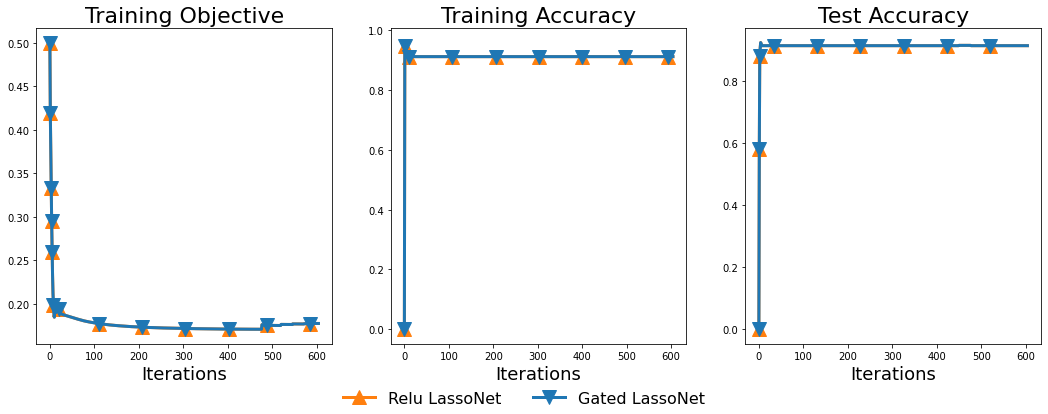

In [25]:
fig = plt.figure(figsize=(18,6))
spec = fig.add_gridspec(ncols=3, nrows=1)
ax0 = fig.add_subplot(spec[0, 0])

ax0.plot(np.arange(len(relu_metrics.objective)), 
         relu_metrics.objective, 
         label="ReLU", 
         color="#ff7f0e",
         marker="^",
         markevery=0.1,
         markersize=14,
         linewidth="3")

ax0.plot(np.arange(len(grelu_metrics.objective)), 
         grelu_metrics.objective, 
         label="Gated ReLU", 
         color="#1f77b4",
         marker="v", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax0.set_title("Training Objective", fontsize=22)
ax0.set_xlabel("Iterations", fontsize=18)

ax1 = fig.add_subplot(spec[0, 1])

ax1.plot(np.arange(len(relu_metrics.train_accuracy)), 
         relu_metrics.train_accuracy, 
         label="Relu", 
         color="#ff7f0e",
         marker="^",
         markevery=0.1,
         markersize=14,
         linewidth="3")

ax1.plot(np.arange(len(grelu_metrics.train_accuracy)), 
         grelu_metrics.train_accuracy, 
         label="Gated ReLU", 
         color="#1f77b4",
         marker="v", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax1.set_title("Training Accuracy", fontsize=22)
ax1.set_xlabel("Iterations", fontsize=18)

ax2 = fig.add_subplot(spec[0, 2])


ax2.plot(np.arange(len(relu_metrics.test_accuracy)), 
         relu_metrics.test_accuracy, 
         label="Relu", 
         color="#ff7f0e",
         marker="^",
         markevery=0.1,
         markersize=14,
         linewidth="3")

ax2.plot(np.arange(len(grelu_metrics.test_accuracy)), 
         grelu_metrics.test_accuracy, 
         label="Gated ReLU", 
         color="#1f77b4",
         marker="v", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax2.set_title("Test Accuracy", fontsize=22)
ax2.set_xlabel("Iterations", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
legend = fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    borderaxespad=0.1,
    fancybox=False,
    shadow=False,
    ncol=2,
    fontsize=16,
    frameon=False,
)
fig.subplots_adjust(
    bottom=0.15,
)